## Problem Statement: Machine Learning 11

#### In this assignment students have to make ARIMA model over shampoo sales data.

In [1]:
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Read the daatset
series = pd.read_csv('shampoo-sales.csv')

##### Exploratory Data Ananlysis

In [3]:
series.head(3)

,Month,Sales of shampoo over a three year period
0,2015-01,266.0
1,2015-02,145.9
2,2015-03,183.1


In [4]:
series.describe()

,Sales of shampoo over a three year period
count,36.000000
mean,312.600000
std,148.937164
min,119.300000
25%,192.450000
50%,280.150000
75%,411.100000
max,682.000000


In [5]:
series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 2 columns):
Month                                        36 non-null object
Sales of shampoo over a three year period    36 non-null float64
dtypes: float64(1), object(1)
memory usage: 656.0+ bytes


In [6]:
series.isna().sum().sum()

0

In [7]:
series.columns = ['Month','Shampoo Sales']
series.head(1)

,Month,Shampoo Sales
0,2015-01,266.0


###### Convert 'Month' to datetime format and set it as index

In [8]:
series['Month'] = pd.to_datetime(series['Month'])

In [9]:
series.set_index('Month',inplace=True)
series.head()

,Shampoo Sales
Month,
2015-01-01,266.0
2015-02-01,145.9
2015-03-01,183.1
2015-04-01,119.3
2015-05-01,180.3


#### Visualize the Data

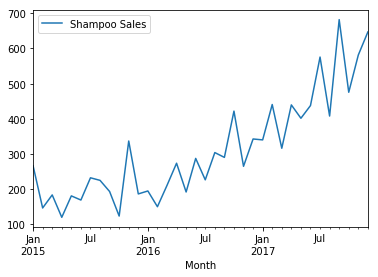

In [10]:
series.plot()

#### Calculate rolling mean and std with lags of 12

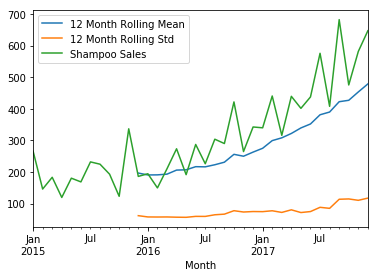

In [11]:
timeseries = series['Shampoo Sales']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

### Decomposition

ETS decomposition allows us to see the individual parts!

<Figure size 432x288 with 0 Axes>

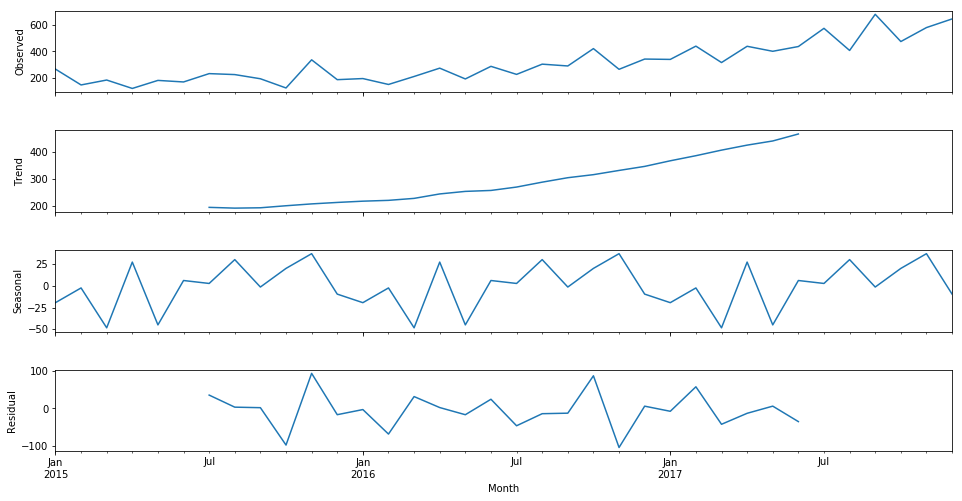

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(series['Shampoo Sales'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [13]:
result = adfuller(series['Shampoo Sales'])

In [14]:
result

(3.060142083641181,
 1.0,
 10,
 25,
 {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004},
 278.9972644263031)

#### Print results of ADF test

In [15]:
# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

### Making Series Stationary

** First Difference **

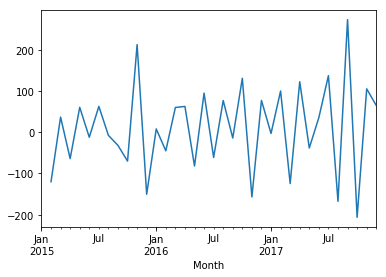

In [16]:
series['Shampoo First Difference'] = series['Shampoo Sales'] - series['Shampoo Sales'].shift(1)
series['Shampoo First Difference'] .plot()

In [17]:
adf_check(series['Shampoo First Difference'] .dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -7.249074055553854
p-value : 1.7998574141687034e-10
#Lags Used : 1
Number of Observations Used : 33
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


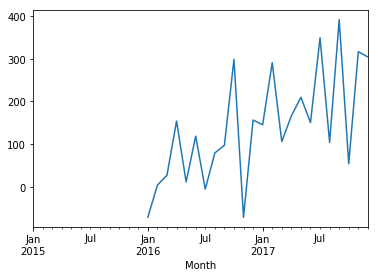

In [18]:
series['Seasonal First Difference'] = series['Shampoo Sales'] - series['Shampoo Sales'].shift(12)
series['Seasonal First Difference'].plot()

In [19]:
adf_check(series['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.04561553414248672
p-value : 0.9545931714075301
#Lags Used : 6
Number of Observations Used : 17
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


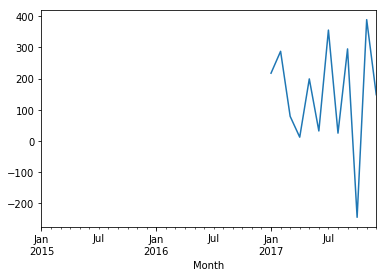

In [20]:
series['Seasonal Second Difference'] = series['Seasonal First Difference'] - series['Seasonal First Difference'].shift(12)
series['Seasonal Second Difference'].plot()

In [21]:
adf_check(series['Seasonal Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : 0.0
p-value : 0.958532086060056
#Lags Used : 5
Number of Observations Used : 6
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1510: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


* Dataset is too small to make third diffrence to attempt to make it statuionsar

#### Autocorrelation

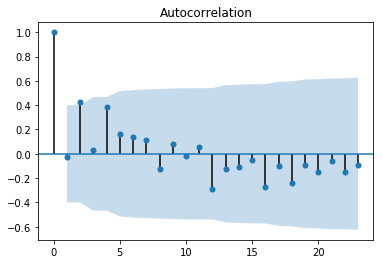

In [22]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig_seasonal_first = plot_acf(series["Seasonal First Difference"].dropna())

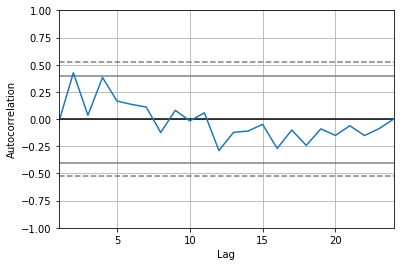

In [23]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series['Seasonal First Difference'].dropna())

#### Partial Autocorrelation

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


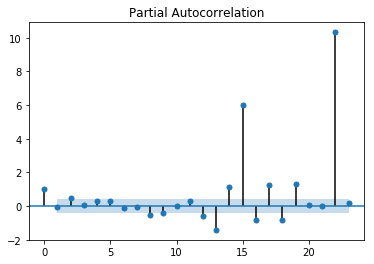

In [24]:
result = plot_pacf(series["Seasonal First Difference"].dropna())

### Final Thoughts on Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.

In [25]:
#### Final ACF and PACF Plots

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


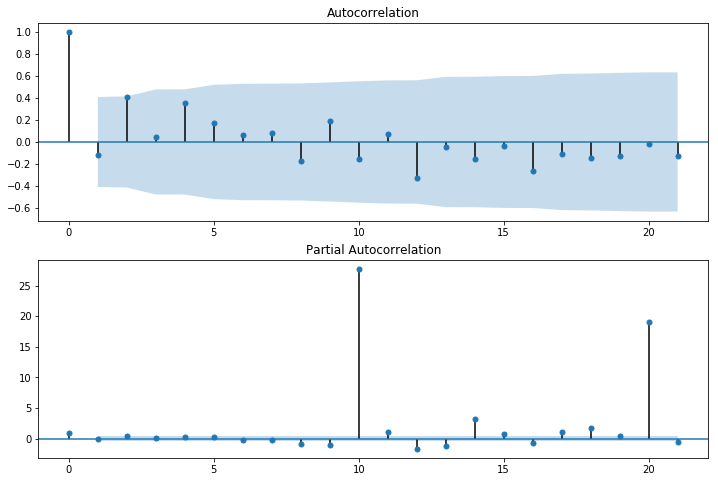

In [26]:
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series['Seasonal First Difference'].iloc[13:], lags=21, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series['Seasonal First Difference'].iloc[13:], lags=21, ax=ax2)


#### Apply ARIMA

In [27]:
series['Shampoo Sales'].dropna(axis=0,inplace=True)
series['Shampoo Sales'].head()

Month
2015-01-01    266.0
2015-02-01    145.9
2015-03-01    183.1
2015-04-01    119.3
2015-05-01    180.3
Name: Shampoo Sales, dtype: float64

In [28]:
series['Shampoo Sales'].isna().sum()

0

In [29]:
 #We have seasonal data!
import statsmodels.api as sm
s_arima_model = sm.tsa.statespace.SARIMAX(series['Shampoo Sales'])
s_arima_results = s_arima_model.fit()
print(s_arima_results.summary())

                           Statespace Model Results                           
Dep. Variable:          Shampoo Sales   No. Observations:                   36
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -220.872
Date:                Sun, 11 Aug 2019   AIC                            445.744
Time:                        14:25:19   BIC                            448.911
Sample:                    01-01-2015   HQIC                           446.849
                         - 12-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9662      0.044     22.071      0.000       0.880       1.052
sigma2      1.159e+04   2908.171      3.984      0.000    5885.111    1.73e+04
Ljung-Box (Q):                       91.62   Jarque-

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


In [30]:
series.columns

Index(['Shampoo Sales', 'Shampoo First Difference',
       'Seasonal First Difference', 'Seasonal Second Difference'],
      dtype='object')

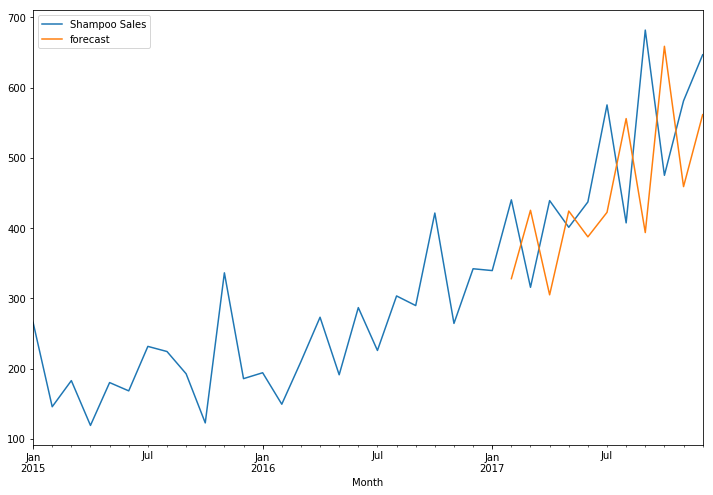

In [31]:
series['forecast'] = s_arima_results.predict(start=25, end=35)
series[['Shampoo Sales','forecast']].plot(figsize=(12,8))